# Setup and Imports 

In [1]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import numpy as np
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
batch_size = 64
workers = 4

dataset = dset.ImageFolder(root="data",
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

# Model Architecture 

In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, color_channels, discriminator_features):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            
            # Input: (input_channels) x 64 x 64
            nn.Conv2d(color_channels, discriminator_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features) x 32 x 32
            
            nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(discriminator_features * 2, affine=True),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*2) x 16 x 16
            
            nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(discriminator_features * 4, affine=True),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*4) x 8 x 8
            
            nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # State size: (discriminator_features*8) x 4 x 4
            
            nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.dis(input).view(-1)    

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, generator_features, color_channels):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, generator_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_features * 8),
            nn.ReLU(),
            # State: (512, 4, 4)

            nn.ConvTranspose2d(generator_features * 8, generator_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 4),
            nn.ReLU(),
            # State: (256, 8, 8)

            nn.ConvTranspose2d(generator_features * 4, generator_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features * 2),
            nn.ReLU(),
            # State: (128, 16, 16)

            nn.ConvTranspose2d(generator_features * 2, generator_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_features),
            nn.ReLU(),
            # State: (64, 32, 32)

            nn.ConvTranspose2d(generator_features, color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (3, 64, 64)
        )

    def forward(self, x):
        return self.gen(x)

In [6]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [7]:
def generate_and_save_fid_samples(generator, num_samples, dir):
    os.makedirs(dir, exist_ok=True)
    generator.eval()
    with torch.no_grad():
        for i in range(num_samples // batch_size + 1):
            z = torch.randn(batch_size, 100, 1, 1).to(device)
            fake_images = generator(z)
            for j, img in enumerate(fake_images):
                idx = i * batch_size + j
                if idx >= num_samples:
                    break
                save_image(img, f"{dir}/sample_{idx}.png", normalize=True)
    generator.train()

# Training 

In [9]:
gnet = Generator(latent_dim=100, generator_features=64, color_channels=3).to(device)
critic = Discriminator(color_channels=3, discriminator_features=64).to(device)

initialize_weights(gnet)
initialize_weights(critic)

g_optim = torch.optim.RMSprop(gnet.parameters(), lr=0.0001)
c_optim = torch.optim.RMSprop(critic.parameters(), lr=0.0001)

In [10]:
import os
os.makedirs("samples", exist_ok=True)
os.makedirs("generated_fid_samples", exist_ok=True)

from tqdm.auto import tqdm

critic_iterations = 5
weight_clip = 0.01

epochs = 50

fixed_noise = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in tqdm(range(epochs)):
    
    for i, (X,_) in enumerate(dataloader):

        real_images = X.to(device)
        batch_size = real_images.size(0)

        #Train critic
        for _ in range(critic_iterations):
            fake_images = gnet(torch.randn(batch_size, 100, 1, 1).to(device))
            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            c_loss = -torch.mean(critic_real) + torch.mean(critic_fake)
            
            critic.zero_grad()
            c_loss.backward(retain_graph=True)
            c_optim.step()

            for p in critic.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        fake_images = gnet(torch.randn(batch_size, 100, 1, 1).to(device))
        #Train generator
        output = critic(fake_images)
        g_loss = -torch.mean(output)
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()
    
    with torch.no_grad():
        fake = gnet(fixed_noise)
        save_image(fake, f"samples/epoch_{epoch}.png", normalize=True)

    if (epoch+1) % 10 == 0:
        generate_and_save_fid_samples(gnet, num_samples=1000, dir="generated_fid_samples")
        
        metrics_dict = calculate_metrics(
            input1="data/data",
            input2="generated_fid_samples",
            cuda=True,
            fid=True,
            isc=False,
            kid=False,
            verbose=False
        )
        
        fid = metrics_dict['frechet_inception_distance']
        print(f"Epoch {epoch}, FID: {fid:.2f}")


C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 18%|██████████████▉                                                                    | 9/50 [12:11<55:32, 81.28s/it]C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
 20%|███████████████▊                                                               | 10/50 [17:42<1:45:34, 158.36s/it]

Epoch 9, FID: 245.13


 40%|███████████████████████████████▌                                               | 20/50 [33:56<1:12:15, 144.52s/it]

Epoch 19, FID: 167.94


 60%|████████████████████████████████████████████████▌                                | 30/50 [50:03<46:56, 140.80s/it]

Epoch 29, FID: 161.74


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [1:06:15<23:50, 143.08s/it]

Epoch 39, FID: 151.65


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:22:47<00:00, 99.35s/it]

Epoch 49, FID: 143.94


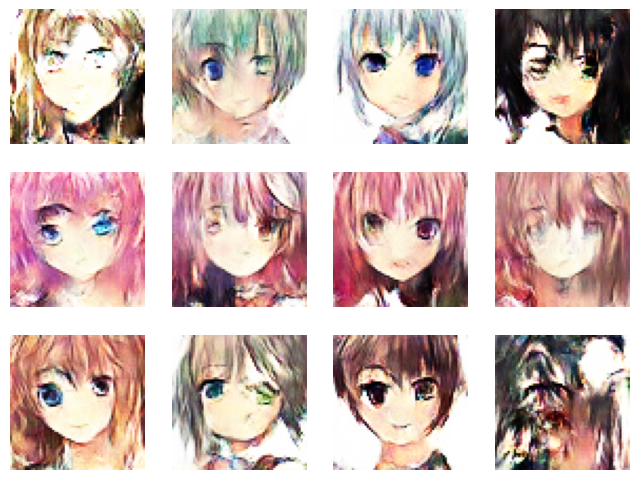

In [13]:
import matplotlib.pyplot as plt

gnet.eval()
with torch.no_grad():
    fake_data = gnet(torch.randn(12, 100, 1, 1).to(device)).cpu()
    
    fake_data = fake_data.permute(0, 2, 3, 1)
    fake_data = (fake_data + 1) / 2 

    fig, axs = plt.subplots(3, 4, figsize=(8, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(fake_data[i])
        ax.axis('off')
    plt.show()

In [14]:

generate_and_save_fid_samples(gnet, num_samples=10000, dir="generated_fid_samples")
        
metrics_dict = calculate_metrics(
    input1="data/data",
    input2="generated_fid_samples",
    cuda=True,
    fid=True,
    isc=False,
    kid=False,
    verbose=False
)
        
fid = metrics_dict['frechet_inception_distance']
print(f"Final FID: {fid:.2f}")

Final FID: 131.17


# Wnioski 
    * Model WGAN jest znacznie bardziej stabilny od DCGAN
    * Trzeba popracowac z hiperparamterami i dac wiecej epok, ale ogolnie efekt zadawalajacy, tym bardziej jak na 1 h 20 min treningu